# Text Detection

- evaluate text detection models
- EAST text detector <https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/>
- CTPN https://github.com/eragonruan/text-detection-ctpn/
- deep text detection <https://github.com/opencv/opencv_contrib/blob/master/modules/text/samples/deeptextdetection.py>

In [138]:
%reload_ext autoreload
%autoreload 2
import os, sys
from os.path import join
import time
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

import numpy as np
import imutils
import cv2 as cv

# append notebook imports folder
sys.path.append(str(Path(os.getcwd()).parent))
from utils import imx

# append vframe imports folder
sys.path.append(str(Path(os.getcwd()).parent.parent/'vframe/'))
from vframe.utils import im_utils, file_utils
from vframe.settings import vframe_cfg as cfg

# crnn
import torch
from torch.autograd import Variable
from PIL import Image

sys.path.append(str(Path(os.getcwd()).parent.parent/'3rdparty/'))
from crnn_pytorch import utils
from crnn_pytorch import dataset
import crnn_pytorch.models.crnn as crnn

# PyTorch CRNN Text Recognition

In [ ]:
model_path = join(cfg.DIR_MODELS_PYTORCH, 'crnn/crnn.pth')
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'

model = crnn.CRNN(32, 1, 37, 256)
if torch.cuda.is_available():
    model = model.cuda()
print('loading pretrained model from %s' % model_path)
model.load_state_dict(torch.load(model_path))
converter = utils.strLabelConverter(alphabet)
transformer = dataset.resizeNormalize((100, 32))

In [133]:
# get a test image
im_test_list = glob(join(cfg.DIR_TEST_IMAGES, 'ocr', '*'))
print('found {} images'.format(len(im_test_list)))

found 17 images


## Deep Text Detection (OpenCV Demo)

In [87]:
# setup model
fp_model = join(cfg.DIR_MODELS_CAFFE, 'deepscenetext', "TextBoxes_icdar13.caffemodel")
fp_prototxt = join(cfg.DIR_MODELS_CAFFE, 'deepscenetext', 'textbox.prototxt')
#textSpotter = cv.text.TextDetectorCNN_create("textbox.prototxt", )
net = cv.text.TextDetectorCNN_create(fp_prototxt, fp_model)


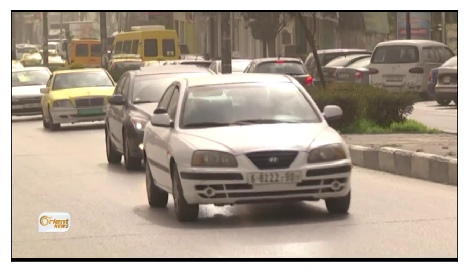

<Figure size 432x288 with 0 Axes>

In [88]:
# get random image
fp_im_test = np.random.choice(im_test_list)
# load
im = cv.imread(fp_im_test)
im_resize = cv.resize(im, dnn_size)
# detect
rects, probs = net.detect(im)
vis = im.copy()
thresh = 0.5
# draw
for r in range(np.shape(rects)[0]):
  if probs[r] > thresh:
    rect = rects[r]
    cv.rectangle(vis, (rect[0],rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 2)
# display
imx.pltimg(vis, mode='bgr')

# EAST Text Detector
- higher performance for finding small text
- lower accuracy on bounding box of large text

In [89]:
import imutils
from imutils.object_detection import non_max_suppression

In [90]:
fp_model = join(cfg.DIR_MODELS_TF, 'east', 'frozen_east_text_detection.pb')
net_east = cv.dnn.readNetFromTensorflow(fp_model)

In [91]:
layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

174


/home/adam/anaconda3/envs/vframe/lib/python3.5/site-packages/numpy/lib/function_base.py:4900: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new = arr[slobj]


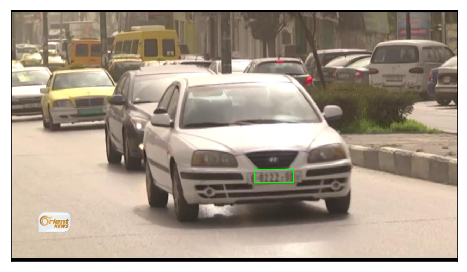

<Figure size 432x288 with 0 Axes>

In [170]:
## get random image
fp_im_test = np.random.choice(im_test_list)
# load
im_orig = cv.imread(fp_im_test)
im = im_orig.copy()
orig = im_orig.copy()
(H, W) = im.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
# (newW, newH) = (320, 320)
(newW, newH) = (32*10, 32*10)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
im = cv.resize(im, (newW, newH))
(H, W) = im.shape[:2]


blob = cv.dnn.blobFromImage(im, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

net_east.setInput(blob)
(scores, geometry) = net_east.forward(layerNames)
# inference

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
  # extract the scores (probabilities), followed by the geometrical
  # data used to derive potential bounding box coordinates that
  # surround text
  scoresData = scores[0, 0, y]
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  anglesData = geometry[0, 4, y]


  # loop over the number of columns
  for x in range(0, numCols):
    # if our score does not have sufficient probability, ignore it
    if scoresData[x] < 0.75:
      continue

    # compute the offset factor as our resulting feature maps will
    # be 4x smaller than the input image
    (offsetX, offsetY) = (x * 4.0, y * 4.0)

    # extract the rotation angle for the prediction and then
    # compute the sin and cosine
    angle = anglesData[x]
    cos = np.cos(angle)
    sin = np.sin(angle)

    # use the geometry volume to derive the width and height of
    # the bounding box
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]

    # compute both the starting and ending (x, y)-coordinates for
    # the text prediction bounding box
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    startX = int(endX - w)
    startY = int(endY - h)

    # add the bounding box coordinates and probability score to
    # our respective lists
    rects.append((startX, startY, endX, endY))
    confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
 
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
  # scale the bounding box coordinates based on the respective
  # ratios
  print(startX)
  startX = int(startX * rW)
  startY = int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)

  # draw the bounding box on the image
  cv.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

imx.pltimg(orig, mode='bgr')


# EAST w/NMS+

In [171]:
import pytesseract

---------------------s---- => s                   
english: , arabic: 


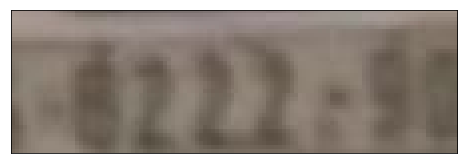

<Figure size 432x288 with 0 Axes>

In [172]:
orig = im_orig.copy()
for (x1, y1, x2, y2) in boxes:
  x1 = int(x1 * rW)
  y1 = int(y1 * rH)
  x2 = int(x2 * rW)
  y2 = int(y2 * rH)

  # draw the bounding box on the image
  im_crop = im_orig[y1:y2, x1:x2]
  im_crop_pil = imx.ensure_pil(im_crop)
  im_crop_pil = im_crop_pil.convert('L')
  im_crop_pil = transformer(im_crop_pil)
  if torch.cuda.is_available():
      im_crop_pil = im_crop_pil.cuda()
  im_crop_pil = im_crop_pil.view(1, *im_crop_pil.size())
  im_crop_pil = Variable(im_crop_pil)

  model.eval()
  preds = model(im_crop_pil)

  _, preds = preds.max(2)
  preds = preds.transpose(1, 0).contiguous().view(-1)

  preds_size = Variable(torch.IntTensor([preds.size(0)]))
  raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
  sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
  print('%-20s => %-20s' % (raw_pred, sim_pred))
  im_crop_pil = imx.ensure_pil(im_crop)
  txt_tess_eng = pytesseract.image_to_string(im_crop_pil, lang='eng')
  txt_tess_ara = pytesseract.image_to_string(im_crop_pil, lang='ara')
  print('english: {}, arabic: {}'.format(txt_tess_eng, txt_tess_ara))
  
  
  imx.pltimg(im_crop, mode='bgr')